<center>基于波函数的流体超分辨研究</center>

传统的超分辨是给定图片a，经过超分辨能够得到精度更高的图片b

我们希望能够在超分辨模型前后进行结构的调整，使得其能够自适应涡旋流体超分辨，为方便后续研究，我们暂且将这个方法的名字成为$Clebsch$流体超分辨。

$Clebsch$流体超分辨分为四个步骤：
我们首先有一些流体的图片集，我们是能够已知其图片的结构的，即网格数据，和网格对应的速度场。
其次，我们能够知道双分量波函数是可以经过公式转换得到对应速度场的，双分量波函数形如$\psi = a+bi+cj+dk$

1. 从任意一张已知的图片出发，我们假设该图片是$128\times 128$，经过$model_A$后我们能够找到$a,b,c,d$，与之对应的，$a,b,c,d$每一个单独的量都应该是$128\times 128$

2. 我们将得到的$a,b,c,d$再经过一个$model_B$，这个$model_B$是一个超分辨模型，然后我们将得到对应的$a,b,c,d$，我们假设其分辨率从128提高到了256

3. 我们需要再训练一个从abcd到速度场的$model_c$，然后我们就能得到256的速度场了。

我们希望经过我们改进后的超分辨模型，能够更加适应用于涡旋的流体现象，因为我们能够chern的文章中验证通过波函数的方法能够较好的捕捉涡结构。


为了能够得到上面的模型，我们需要逐步训练各个部分模型，这项工作，只是进行一个简单的尝试，因此，我们会对采用精度较低的图片，以提高模型的训练速度，来验证本项工作的可行性。

# model_A 训练
我们首先进行$model_A $的训练，即：

给定一个速度场后，训练得到波函数的$a,b,c,d$分量。



## 一维问题

我们首先构造较为简单的一维算例

$$
a(x,t) = sin(x - t)\\
b(x,t) = cos(x + t)\\
c(x,t) = sin(x + t)\\
d(x,t) = cos(x - t)\\
$$

$$
x\in(-\pi, \pi)\\
t\in(0, 10)\\
\bar h=1
$$
因此，双分量波函数可以表示为如下形式:
$$
\mathbf{\psi}=[\psi_1, \psi_2]^T=[sin(x - t)+icos(x + t), sin(x + t)+icos(x - t)]^T
$$
根据公式
$$
u = \hbar \langle \nabla \psi, i \psi \rangle_{\mathbb{R}} = \hbar (a \nabla b - b \nabla a + c \nabla d - d \nabla c),

$$

我们可以计算出对应的速度场为：
$$
u=2sin(t-x)sin(t+x)-2cos(t-x)cos(t+x)
$$

In [20]:
import sympy as sp

# 定义符号
x = sp.symbols('x')

sqrt_2_over_2 = 1/ (2*sp.sqrt(sp.pi))

# 定义函数
a = sqrt_2_over_2 *sp.cos(x)
b = sqrt_2_over_2 *sp.sin(x)
c = sqrt_2_over_2 *sp.cos(x)
d = sqrt_2_over_2 *sp.sin(x)

# 计算模平方
mod_a_sq = a**2
mod_b_sq = b**2
mod_c_sq = c**2
mod_d_sq = d**2

# 总模平方
mod_psi_sq = mod_a_sq + mod_b_sq + mod_c_sq + mod_d_sq

# 计算归一化积分
integral = sp.integrate(mod_psi_sq, (x, -sp.pi, sp.pi))
normalized = integral
print(f'归一化约束: {normalized}')

# 计算拉普拉斯算子
laplacian_a = sp.diff(a, x, x)
laplacian_b = sp.diff(b, x, x)
laplacian_c = sp.diff(c, x, x)
laplacian_d = sp.diff(d, x, x)

# 计算散度自由约束积分
div_free_integral = sp.integrate(laplacian_a * sp.I * b + laplacian_b * sp.I * a + laplacian_c * sp.I * d + laplacian_d * sp.I * c, (x, -sp.pi, sp.pi))
print(f'散度自由约束: {div_free_integral}')


归一化约束: 1
散度自由约束: 0


In [15]:
import sympy as sp

# 定义符号
x, t = sp.symbols('x t')

# 定义 a, b, c, d
a = sp.sin(x - t)
b = sp.cos(x + t)
c = sp.sin(x + t)
d = sp.cos(x - t)

# 定义 psi
psi1 = a + sp.I * b
psi2 = c + sp.I * d

# 计算模平方
mod_psi1_sq = sp.Abs(psi1)**2
mod_psi2_sq = sp.Abs(psi2)**2

# 总模平方
mod_psi_sq = mod_psi1_sq + mod_psi2_sq

# 计算归一化积分
norm_integral = sp.integrate(mod_psi_sq, (x, -sp.pi, sp.pi), (t, 0, 10))
norm_integral

4*pi*(-sin(10)*cos(10)/2 + 5) + 4*pi*(sin(10)*cos(10)/2 + 5)

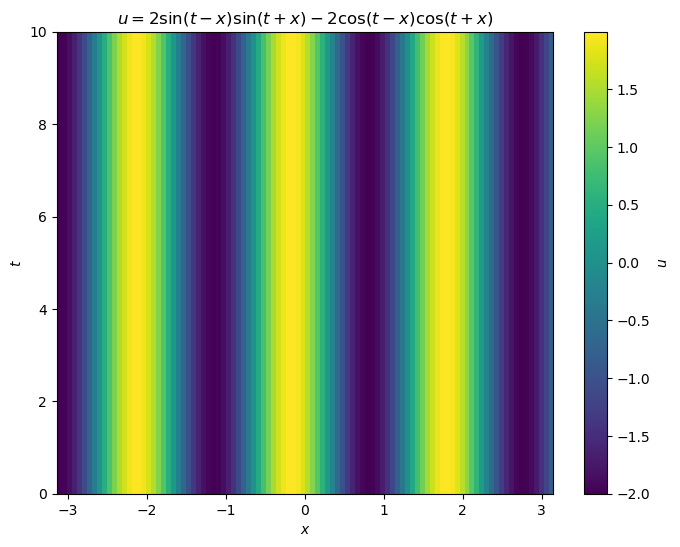

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 定义网格
size = 100
x = np.linspace(-np.pi, np.pi, size)
t = np.linspace(0, 10, size)
X, T = np.meshgrid(x, t, indexing='ij')

# 计算速度场
u = 2 * np.sin(T - X) * np.sin(T + X) - 2 * np.cos(T - X) * np.cos(T + X)

# 绘制速度场
plt.figure(figsize=(8, 6))
plt.imshow(u, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='$u$')
plt.title('$u = 2\sin(t-x)\sin(t+x) - 2\cos(t-x)\cos(t+x)$')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.show()


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [22]:
def generate_data(num_samples, size):
    x = np.linspace(-np.pi, np.pi, size)
    t = np.linspace(0, 10, size)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.sin(X - T)
        b = np.cos(X + T)
        c = np.sin(X + T)
        d = np.cos(X - T)
        
        # 计算梯度
        dx = x[1] - x[0]
        a_grad_x, a_grad_y = np.gradient(a, dx, dx)
        b_grad_x, b_grad_y = np.gradient(b, dx, dx)
        c_grad_x, c_grad_y = np.gradient(c, dx, dx)
        d_grad_x, d_grad_y = np.gradient(d, dx, dx)
        
        # 根据公式计算u
        u = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
        data.append((u, np.stack((a, b, c, d), axis=0)))
    return data


In [23]:
# 准备训练和测试数据
num_samples = 2000
size = 10  # 将数据尺寸调整为 10x10
data = generate_data(num_samples, size)
train_data = data[:1000]
test_data = data[1000:]
shared_train_data = train_data
shared_test_data = test_data


In [24]:
# 自定义数据集
class VelocityDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        u, params = self.data[idx]
        return torch.tensor(u, dtype=torch.float32).unsqueeze(0), torch.tensor(params, dtype=torch.float32)


In [6]:
train_dataset = VelocityDataset(shared_train_data)
test_dataset = VelocityDataset(shared_test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [29]:
class VelocityPredictor(nn.Module):
    def __init__(self, size):
        super(VelocityPredictor, self).__init__()
        self.size = size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * size * size, 512)  # 128 channels * size * size
        self.fc2 = nn.Linear(512, 4 * size * size)    # 4 channels * size * size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, self.size, self.size)  # Reshape the output tensor
        return x


In [30]:
# 计算速度场
def compute_velocity(a, b, c, d):
    dx = 1.0 / a.size(-1)  # 假设均匀网格
    a_grad_x, a_grad_y = torch.gradient(a, spacing=(dx, dx), dim=(1, 2))
    b_grad_x, b_grad_y = torch.gradient(b, spacing=(dx, dx), dim=(1, 2))
    c_grad_x, c_grad_y = torch.gradient(c, spacing=(dx, dx), dim=(1, 2))
    d_grad_x, d_grad_y = torch.gradient(d, spacing=(dx, dx), dim=(1, 2))

    u_pre_x = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
    u_pre_y = a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y

    return u_pre_x + u_pre_y


In [31]:
# 训练模型
num_epochs = 10
size = 32  # 调整分辨率
model = VelocityPredictor(size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()





In [32]:

# 训练模型
for epoch in range(num_epochs):
    model.train()
    for u, params in train_loader:
        optimizer.zero_grad()
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :].requires_grad_(True)
        b = outputs[:, 1, :, :].requires_grad_(True)
        c = outputs[:, 2, :, :].requires_grad_(True)
        d = outputs[:, 3, :, :].requires_grad_(True)
        
        u_pred = compute_velocity(a, b, c, d)
        loss = criterion(u_pred, u.squeeze(1))
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x12800 and 131072x512)

In [10]:
# 测试模型
model.eval()
with torch.no_grad():
    test_targets = []
    test_predictions = []
    a_predictions = []
    b_predictions = []
    c_predictions = []
    d_predictions = []
    
    for u, params in test_loader:
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(a, b, c, d)
        test_targets.append(u.numpy())
        test_predictions.append(u_pred.numpy())
        
        a_predictions.append(a.numpy())
        b_predictions.append(b.numpy())
        c_predictions.append(c.numpy())
        d_predictions.append(d.numpy())

    test_targets = np.concatenate(test_targets)
    test_predictions = np.concatenate(test_predictions)
    a_predictions = np.concatenate(a_predictions)
    b_predictions = np.concatenate(b_predictions)
    c_predictions = np.concatenate(c_predictions)
    d_predictions = np.concatenate(d_predictions)

    mse = mean_squared_error(test_targets.flatten(), test_predictions.flatten())
    mae= mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    r2 = r2_score(test_targets.flatten(), test_predictions.flatten())

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')



Test Mean Squared Error: 1.5778551764309735e-14
Test Mean Absolute Error: 9.236872244855476e-08
Test R^2 Score: 1.0


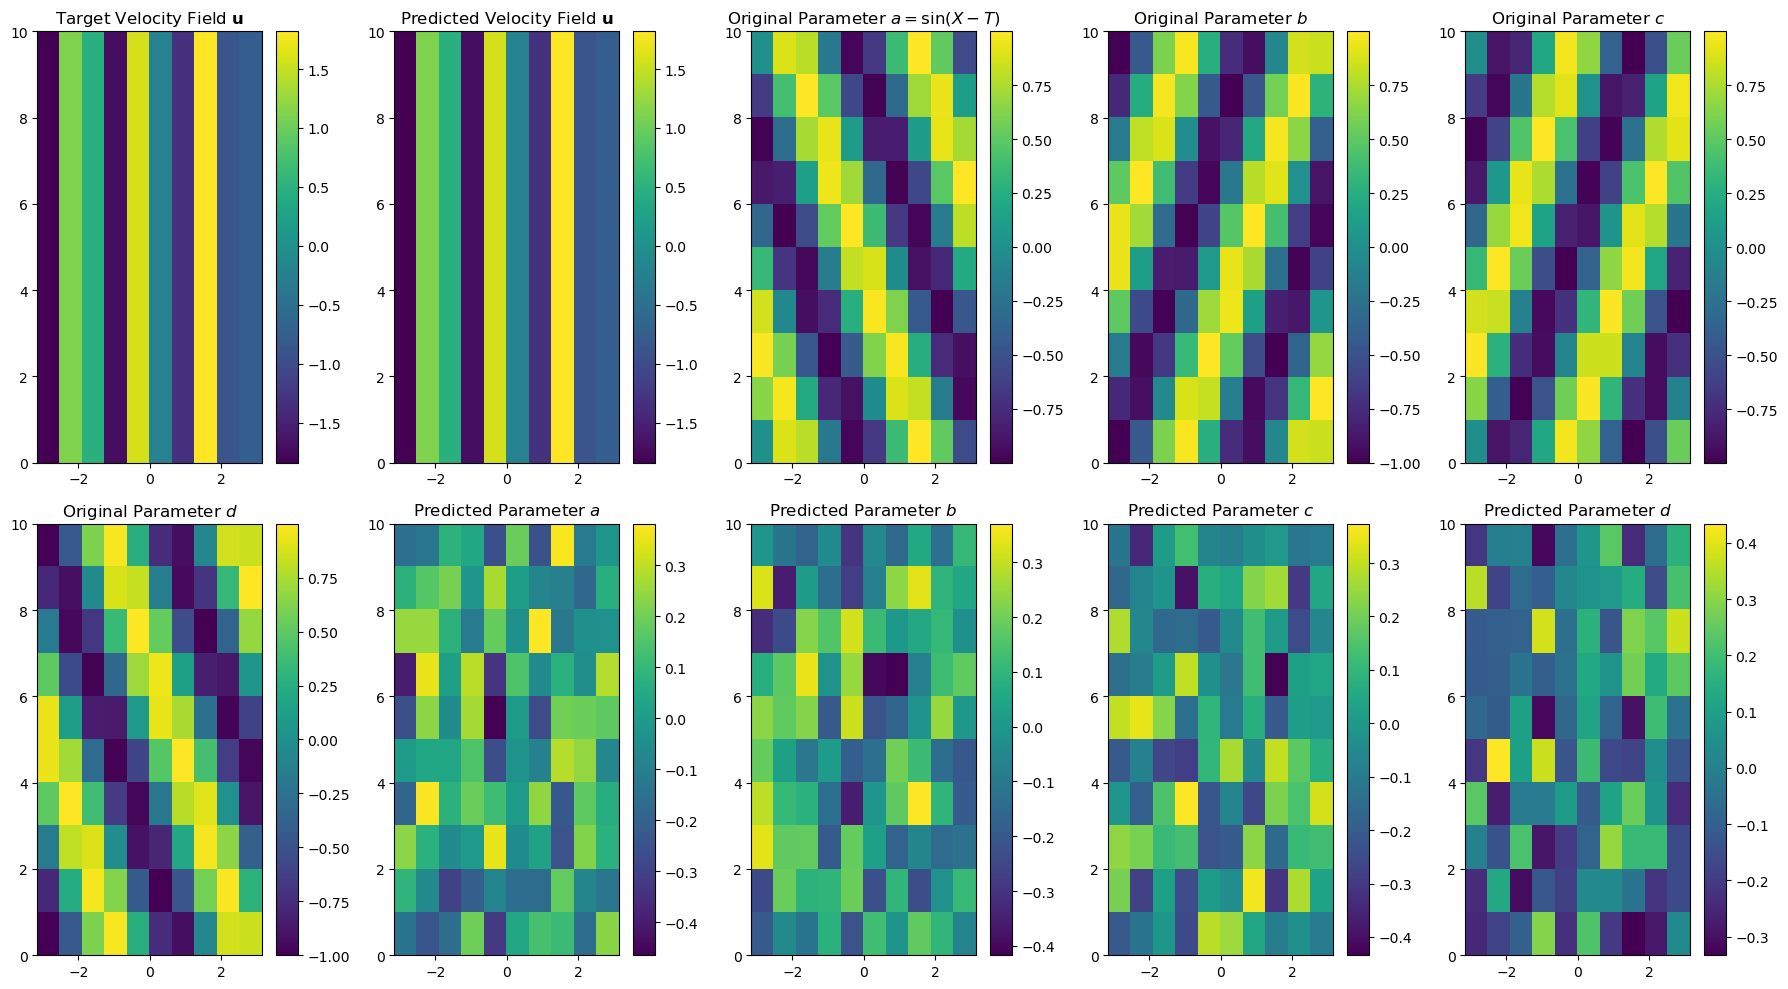

In [13]:
# 可视化结果
plt.figure(figsize=(18, 10))

# 绘制目标速度场
plt.subplot(2, 5, 1)
plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Target Velocity Field $\\mathbf{u}$')

# 绘制预测速度场
plt.subplot(2, 5, 2)
plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Velocity Field $\\mathbf{u}$')

# 绘制原始和预测的 a 参数对比图
plt.subplot(2, 5, 3)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $a = \sin(X - T)$')

plt.subplot(2, 5, 7)
plt.imshow(a_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $a$')

# 绘制原始和预测的 b 参数对比图
plt.subplot(2,5, 4)
plt.imshow(np.cos(np.linspace(-np.pi, np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $b$')

plt.subplot(2, 5, 8)
plt.imshow(b_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $b$')

# 绘制原始和预测的 c 参数对比图
plt.subplot(2, 5, 5)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $c$')

plt.subplot(2, 5, 9)
plt.imshow(c_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $c$')

# 绘制原始和预测的 d 参数对比图
plt.subplot(2, 5, 6)
plt.imshow(np.cos(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $d$')

plt.subplot(2, 5, 10)
plt.imshow(d_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $d$')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 生成数据
def generate_data(num_samples, size):
    x = np.linspace(-np.pi, np.pi, size)
    t = np.linspace(0, 10, size)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.sin(X - T)
        b = np.cos(X + T)
        c = np.sin(X + T)
        d = np.cos(X - T)
        
        # 计算梯度
        dx = x[1] - x[0]
        a_grad_x, a_grad_y = np.gradient(a, dx, dx)
        b_grad_x, b_grad_y = np.gradient(b, dx, dx)
        c_grad_x, c_grad_y = np.gradient(c, dx, dx)
        d_grad_x, d_grad_y = np.gradient(d, dx, dx)
        
        # 根据公式计算u
        u = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
        data.append((u, np.stack((a, b, c, d), axis=0)))
    return data

# 准备训练和测试数据
num_samples = 2000
size = 32  # 调整分辨率为 32x32
data = generate_data(num_samples, size)
train_data = data[:1000]
test_data = data[1000:]
shared_train_data = train_data
shared_test_data = test_data

# 自定义数据集
class VelocityDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        u, params = self.data[idx]
        return torch.tensor(u, dtype=torch.float32).unsqueeze(0), torch.tensor(params, dtype=torch.float32)

train_dataset = VelocityDataset(shared_train_data)
test_dataset = VelocityDataset(shared_test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# 模型定义
class VelocityPredictor(nn.Module):
    def __init__(self, size):
        super(VelocityPredictor, self).__init__()
        self.size = size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * size * size, 512)  # 128 channels * size * size
        self.fc2 = nn.Linear(512, 4 * size * size)    # 4 channels * size * size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, self.size, self.size)  # Reshape the output tensor
        return x

# 计算速度场
def compute_velocity(a, b, c, d):
    dx = 1.0 / a.size(-1)  # 假设均匀网格
    a_grad_x, a_grad_y = torch.gradient(a, spacing=(dx, dx), dim=(1, 2))
    b_grad_x, b_grad_y = torch.gradient(b, spacing=(dx, dx), dim=(1, 2))
    c_grad_x, c_grad_y = torch.gradient(c, spacing=(dx, dx), dim=(1, 2))
    d_grad_x, d_grad_y = torch.gradient(d, spacing=(dx, dx), dim=(1, 2))

    u_pre_x = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
    u_pre_y = a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y

    return u_pre_x + u_pre_y

# 训练模型
num_epochs = 10
model = VelocityPredictor(size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    for u, params in train_loader:
        optimizer.zero_grad()
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :].requires_grad_(True)
        b = outputs[:, 1, :, :].requires_grad_(True)
        c = outputs[:, 2, :, :].requires_grad_(True)
        d = outputs[:, 3, :, :].requires_grad_(True)
        
        u_pred = compute_velocity(a, b, c, d)
        loss = criterion(u_pred, u.squeeze(1))
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 测试模型
model.eval()
with torch.no_grad():
    test_targets = []
    test_predictions = []
    a_predictions = []
    b_predictions = []
    c_predictions = []
    d_predictions = []
    
    for u, params in test_loader:
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(a, b, c, d)
        test_targets.append(u.numpy())
        test_predictions.append(u_pred.numpy())
        
        a_predictions.append(a.numpy())
        b_predictions.append(b.numpy())
        c_predictions.append(c.numpy())
        d_predictions.append(d.numpy())

    if test_targets:
        test_targets = np.concatenate(test_targets)
        test_predictions = np.concatenate(test_predictions)
    else:
        test_targets = np.array(test_targets)
        test_predictions = np.array(test_predictions)

    if a_predictions:
        a_predictions = np.concatenate(a_predictions)
        b_predictions = np.concatenate(b_predictions)
        c_predictions = np.concatenate(c_predictions)
        d_predictions = np.concatenate(d_predictions)
    else:
        a_predictions = np.array(a_predictions)
        b_predictions = np.array(b_predictions)
        c_predictions = np.array(c_predictions)
        d_predictions = np.array(d_predictions)

    mse = mean_squared_error(test_targets.flatten(), test_predictions.flatten())
    mae = mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    r2 = r2_score(test_targets.flatten(), test_predictions.flatten())

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')




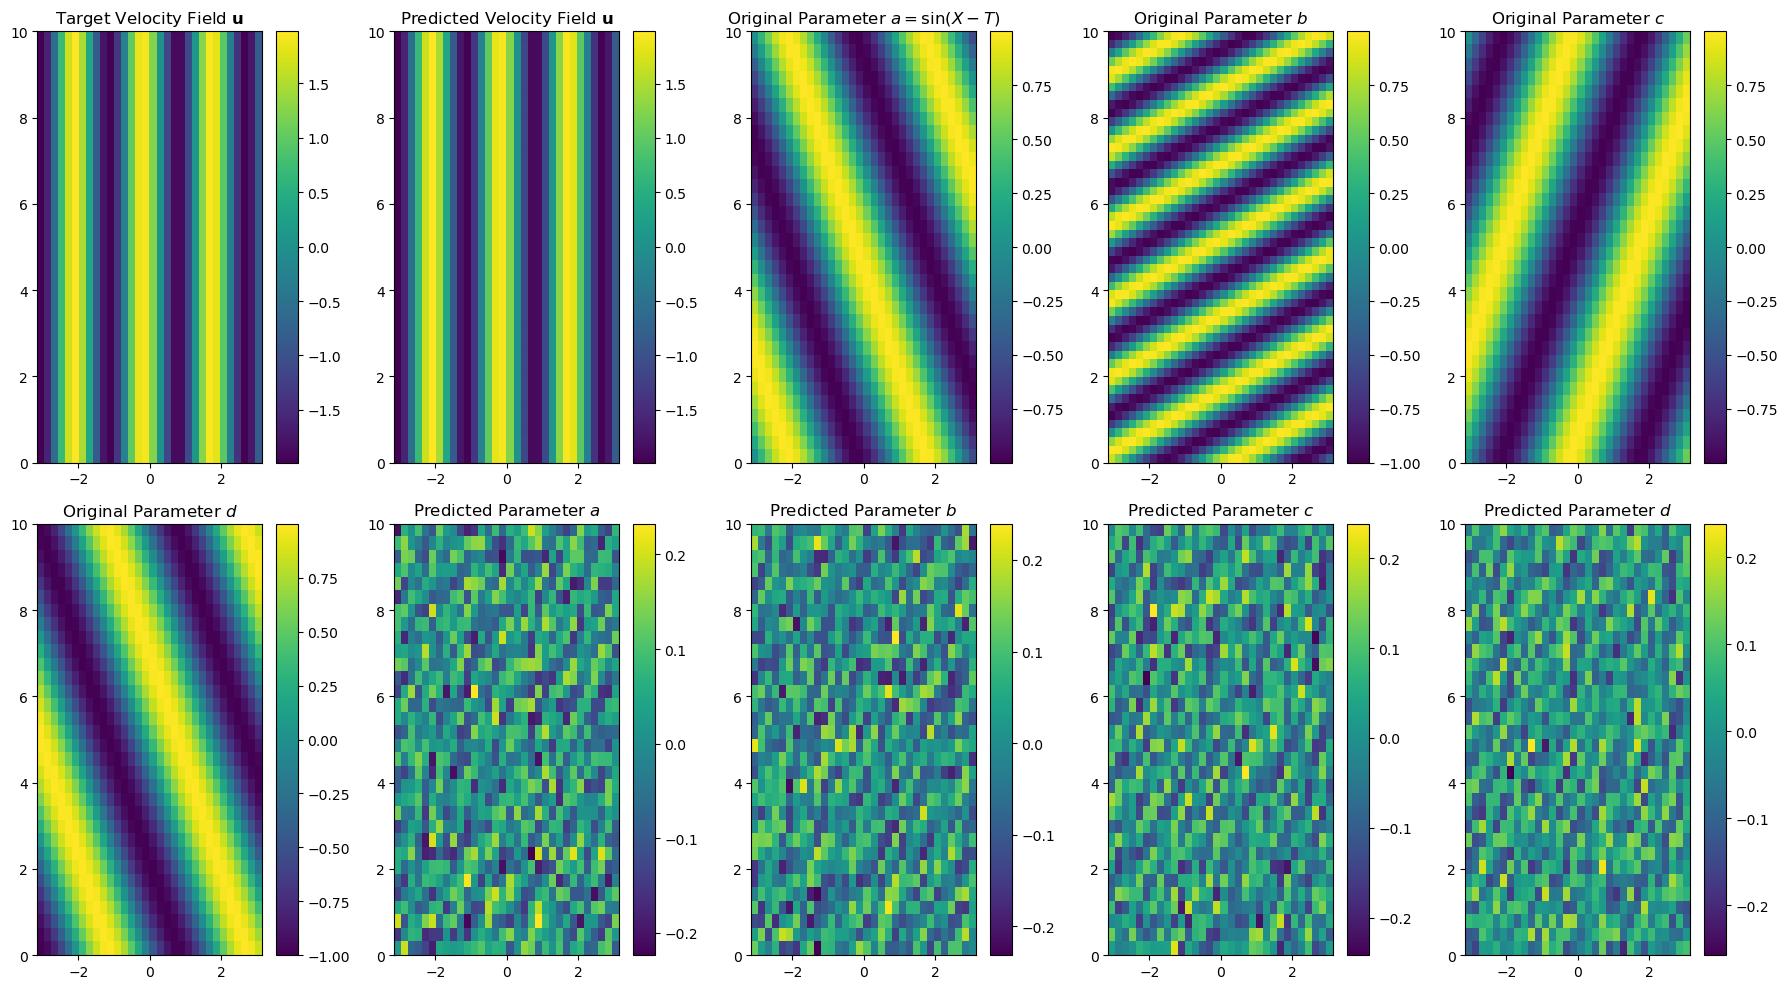

In [39]:
# 可视化结果
plt.figure(figsize=(18, 10))

# 绘制目标速度场
plt.subplot(2, 5, 1)
if test_targets.size > 0:
    plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Target Velocity Field $\\mathbf{u}$')

# 绘制预测速度场
plt.subplot(2, 5, 2)
if test_predictions.size > 0:
    plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Velocity Field $\\mathbf{u}$')

# 绘制原始和预测的 a 参数对比图
plt.subplot(2, 5, 3)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $a = \sin(X - T)$')

plt.subplot(2, 5, 7)
if a_predictions.size > 0:
    plt.imshow(a_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $a$')

# 绘制原始和预测的 b 参数对比图
plt.subplot(2, 5, 4)
plt.imshow(np.cos(np.linspace(-np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $b$')

plt.subplot(2, 5, 8)
if b_predictions.size > 0:
    plt.imshow(b_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $b$')

# 绘制原始和预测的 c 参数对比图
plt.subplot(2, 5, 5)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $c$')

plt.subplot(2, 5, 9)
if c_predictions.size > 0:
    plt.imshow(c_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $c$')

# 绘制原始和预测的 d 参数对比图
plt.subplot(2, 5, 6)
plt.imshow(np.cos(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $d$')

plt.subplot(2, 5, 10)
if d_predictions.size > 0:
    plt.imshow(d_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $d$')

plt.tight_layout()
plt.show()

这里我们使用梯度去检查一下我们的得到abcd经过梯度的计算再计算得到速度场是不是对的，从效果上看是对的。

In [45]:
aCopy = a_predictions[0].squeeze().copy()
bCopy = b_predictions[0].squeeze().copy()
cCopy = c_predictions[0].squeeze().copy()
dCopy = d_predictions[0].squeeze().copy()

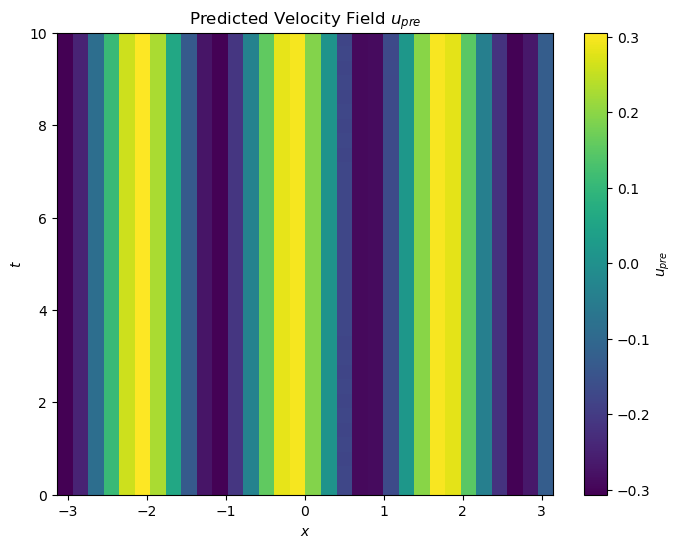

In [46]:
import numpy as np

def compute_u(a, b, c, d, dx):
    # 计算梯度
    a_grad_x, a_grad_y = np.gradient(a, dx, dx)
    b_grad_x, b_grad_y = np.gradient(b, dx, dx)
    c_grad_x, c_grad_y = np.gradient(c, dx, dx)
    d_grad_x, d_grad_y = np.gradient(d, dx, dx)
    
    # 根据公式计算u
    u_pre_x = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
    u_pre_y = a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y

    u_pre = u_pre_x + u_pre_y
    return u_pre

# 假设均匀网格，计算dx
x = np.linspace(-np.pi, np.pi, aCopy.shape[0])
dx = x[1] - x[0]

# 计算u
u_pre = compute_u(aCopy, bCopy, cCopy, dCopy, dx)

# 可视化结果
plt.figure(figsize=(8, 6))
plt.imshow(u_pre, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='$u_{pre}$')
plt.title('Predicted Velocity Field $u_{pre}$')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.show()


我们尽管可以通过模型A得到目标，即从速度场得到对应的abcd，但这里面似乎存在一定的问题，即，从速度场找到的abcd并不唯一。

## 二维问题

# model B 训练（超分辨模型）

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# 定义数据集类
class ABCDFieldDataset(Dataset):
    def __init__(self, low_res_data):
        self.low_res_data = low_res_data

    def __len__(self):
        return len(self.low_res_data)

    def __getitem__(self, idx):
        return self.low_res_data[idx]

# 准备低分辨率数据
aCopy = a_predictions[0].squeeze().copy()
bCopy = b_predictions[0].squeeze().copy()
cCopy = c_predictions[0].squeeze().copy()
dCopy = d_predictions[0].squeeze().copy()

low_res_data = np.stack([aCopy, bCopy, cCopy, dCopy], axis=0)

# 创建 DataLoader
batch_size = 1
train_dataset = ABCDFieldDataset(torch.tensor(low_res_data).unsqueeze(1).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 定义一个简单的超分辨率CNN模型
class SRCNN(nn.Module):
    def __init__(self, upscale_factor):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.upsample = nn.ConvTranspose2d(32, 32, kernel_size=upscale_factor, stride=upscale_factor, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.upsample(x)
        x = self.conv3(x)
        return x

# 初始化模型、损失函数和优化器
upscale_factor = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRCNN(upscale_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for low_res in train_loader:
        low_res = low_res.to(device)
        high_res = torch.nn.functional.interpolate(low_res, scale_factor=upscale_factor, mode='bilinear', align_corners=False)

        optimizer.zero_grad()
        outputs = model(low_res)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * low_res.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# 测试模型
model.eval()
with torch.no_grad():
    low_res_sample = torch.tensor(low_res_data).unsqueeze(1).float().to(device)
    output_sample = model(low_res_sample).cpu().numpy()




Epoch 1/100, Loss: 0.0042
Epoch 2/100, Loss: 0.0040
Epoch 3/100, Loss: 0.0036
Epoch 4/100, Loss: 0.0027
Epoch 5/100, Loss: 0.0016
Epoch 6/100, Loss: 0.0014
Epoch 7/100, Loss: 0.0009
Epoch 8/100, Loss: 0.0007
Epoch 9/100, Loss: 0.0006
Epoch 10/100, Loss: 0.0005
Epoch 11/100, Loss: 0.0004
Epoch 12/100, Loss: 0.0003
Epoch 13/100, Loss: 0.0003
Epoch 14/100, Loss: 0.0002
Epoch 15/100, Loss: 0.0002
Epoch 16/100, Loss: 0.0002
Epoch 17/100, Loss: 0.0002
Epoch 18/100, Loss: 0.0002
Epoch 19/100, Loss: 0.0002
Epoch 20/100, Loss: 0.0002
Epoch 21/100, Loss: 0.0001
Epoch 22/100, Loss: 0.0001
Epoch 23/100, Loss: 0.0001
Epoch 24/100, Loss: 0.0001
Epoch 25/100, Loss: 0.0001
Epoch 26/100, Loss: 0.0001
Epoch 27/100, Loss: 0.0001
Epoch 28/100, Loss: 0.0001
Epoch 29/100, Loss: 0.0001
Epoch 30/100, Loss: 0.0001
Epoch 31/100, Loss: 0.0001
Epoch 32/100, Loss: 0.0001
Epoch 33/100, Loss: 0.0001
Epoch 34/100, Loss: 0.0002
Epoch 35/100, Loss: 0.0001
Epoch 36/100, Loss: 0.0001
Epoch 37/100, Loss: 0.0001
Epoch 38/1

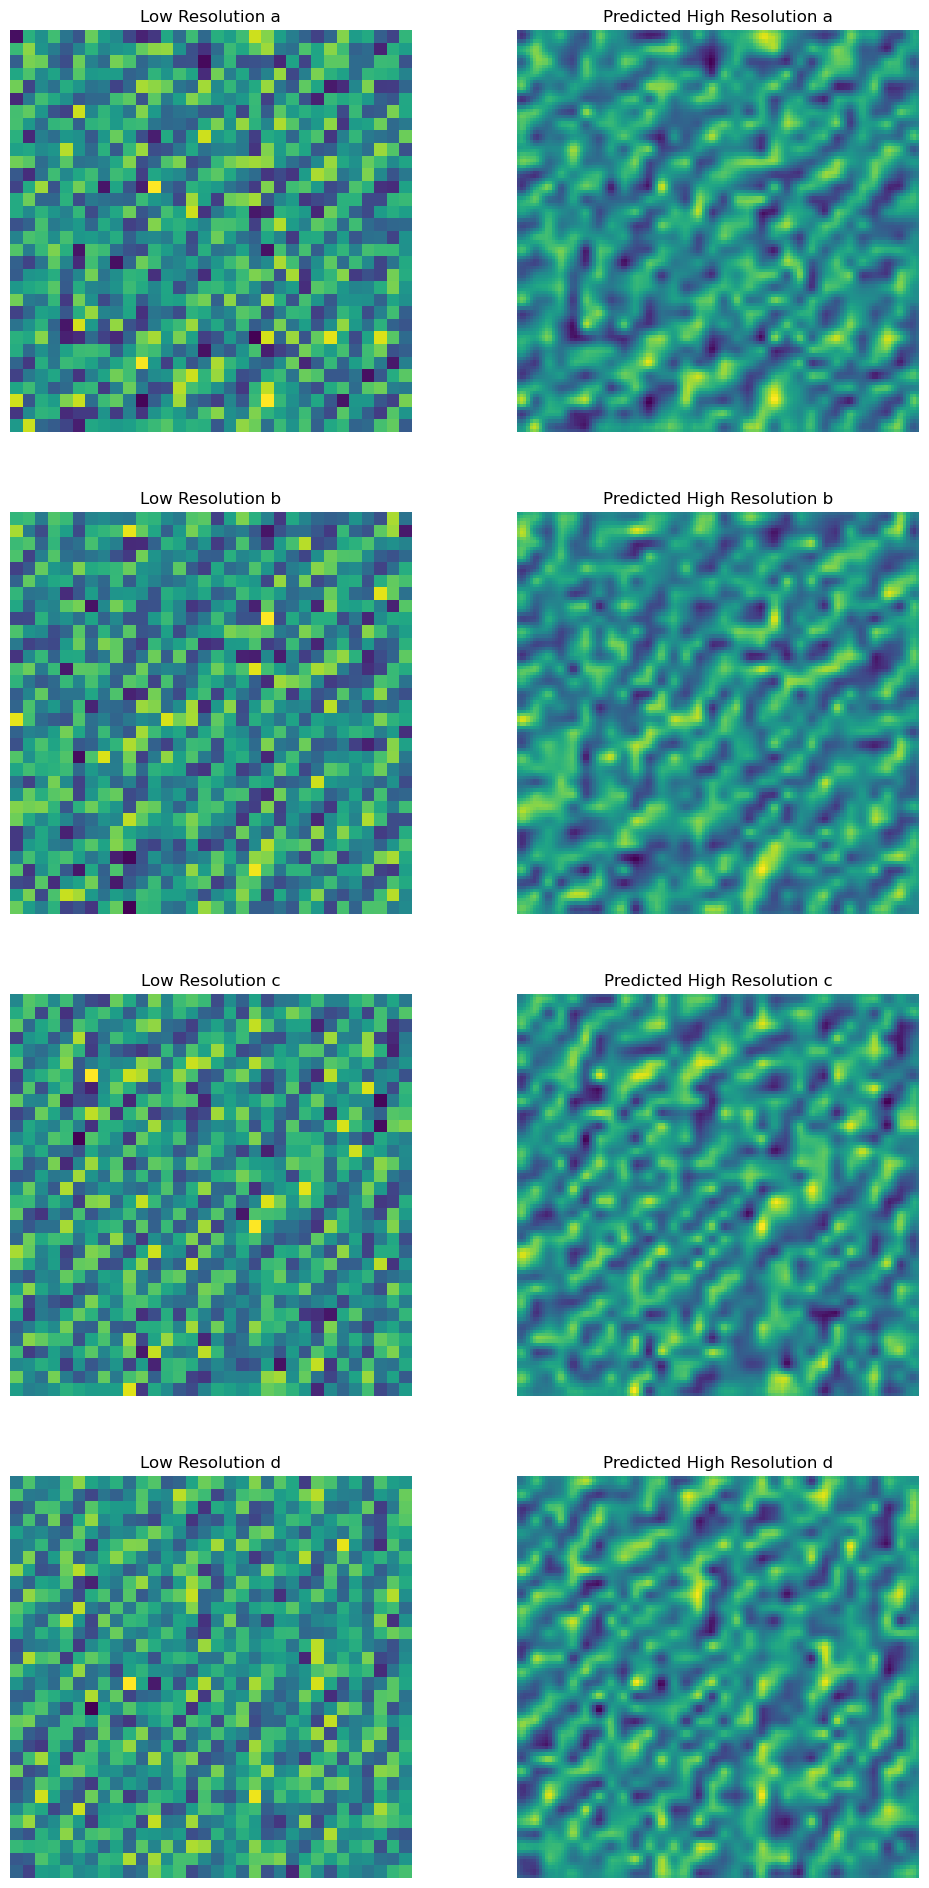

In [66]:
# 可视化结果
fig, axs = plt.subplots(4, 2, figsize=(12, 24))

fields = ['a', 'b', 'c', 'd']
for i in range(4):
    axs[i, 0].imshow(low_res_data[i], cmap='viridis', interpolation='nearest')
    axs[i, 0].set_title(f'Low Resolution {fields[i]}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(output_sample[i][0], cmap='viridis', interpolation='nearest')
    axs[i, 1].set_title(f'Predicted High Resolution {fields[i]}')
    axs[i, 1].axis('off')

plt.show()

In [67]:
output_sample.shape

(4, 1, 128, 128)

In [68]:
a_high_res = output_sample[0][0]
b_high_res = output_sample[1][0]
c_high_res = output_sample[2][0]
d_high_res = output_sample[3][0]

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(a_high_res, cmap='viridis', interpolation='nearest')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(b_high_res, cmap='viridis', interpolation='nearest')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(c_high_res, cmap='viridis', interpolation='nearest')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(d_high_res, cmap='viridis', interpolation='nearest')
plt.colorbar()

In [74]:
a_high_res.shape[0]

128

In [75]:
x = np.linspace(-np.pi, np.pi, a_high_res.shape[0])
dx = x[1] - x[0]


In [76]:
u_pre_128 = compute_u(a_high_res, b_high_res, c_high_res, d_high_res, dx)

In [79]:
u_pre_128.shape

(128, 128)

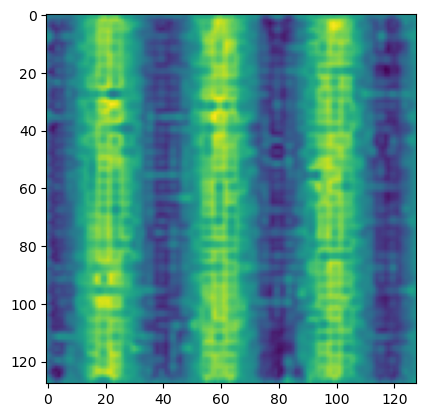

In [77]:
plt.imshow(u_pre_128)

In [82]:
# 保存变量
np.save("aCopy.npy", aCopy)
np.save("bCopy.npy", bCopy)
np.save("cCopy.npy", cCopy)
np.save("dCopy.npy", dCopy)

## 尝试使用cyclgan来试试

In [1]:
import paddle as pd
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
aCopy = np.load("aCopy.npy")
bCopy = np.load("bCopy.npy")
cCopy = np.load("cCopy.npy")
dCopy = np.load("dCopy.npy")

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\paddle\nn\layer\layers.py:2084: UserWarning: Skip loading for conv1.weight. conv1.weight is not found in the provided dict.
  warnings.warn(f"Skip loading for {key}. " + str(err))
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\paddle\nn\layer\layers.py:2084: UserWarning: Skip loading for conv1.bias. conv1.bias is not found in the provided dict.
  warnings.warn(f"Skip loading for {key}. " + str(err))
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\paddle\nn\layer\layers.py:2084: UserWarning: Skip loading for conv2.weight. conv2.weight is not found in the provided dict.
  warnings.warn(f"Skip loading for {key}. " + str(err))
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\paddle\nn\layer\layers.py:2084: UserWarning: Skip loading for conv2.bias. conv2.bias is not found in the provided dict.
  warnings.warn(f"Skip loading for {key}. " + str(err))
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\paddle\nn\lay

[4, 1, 64, 64]


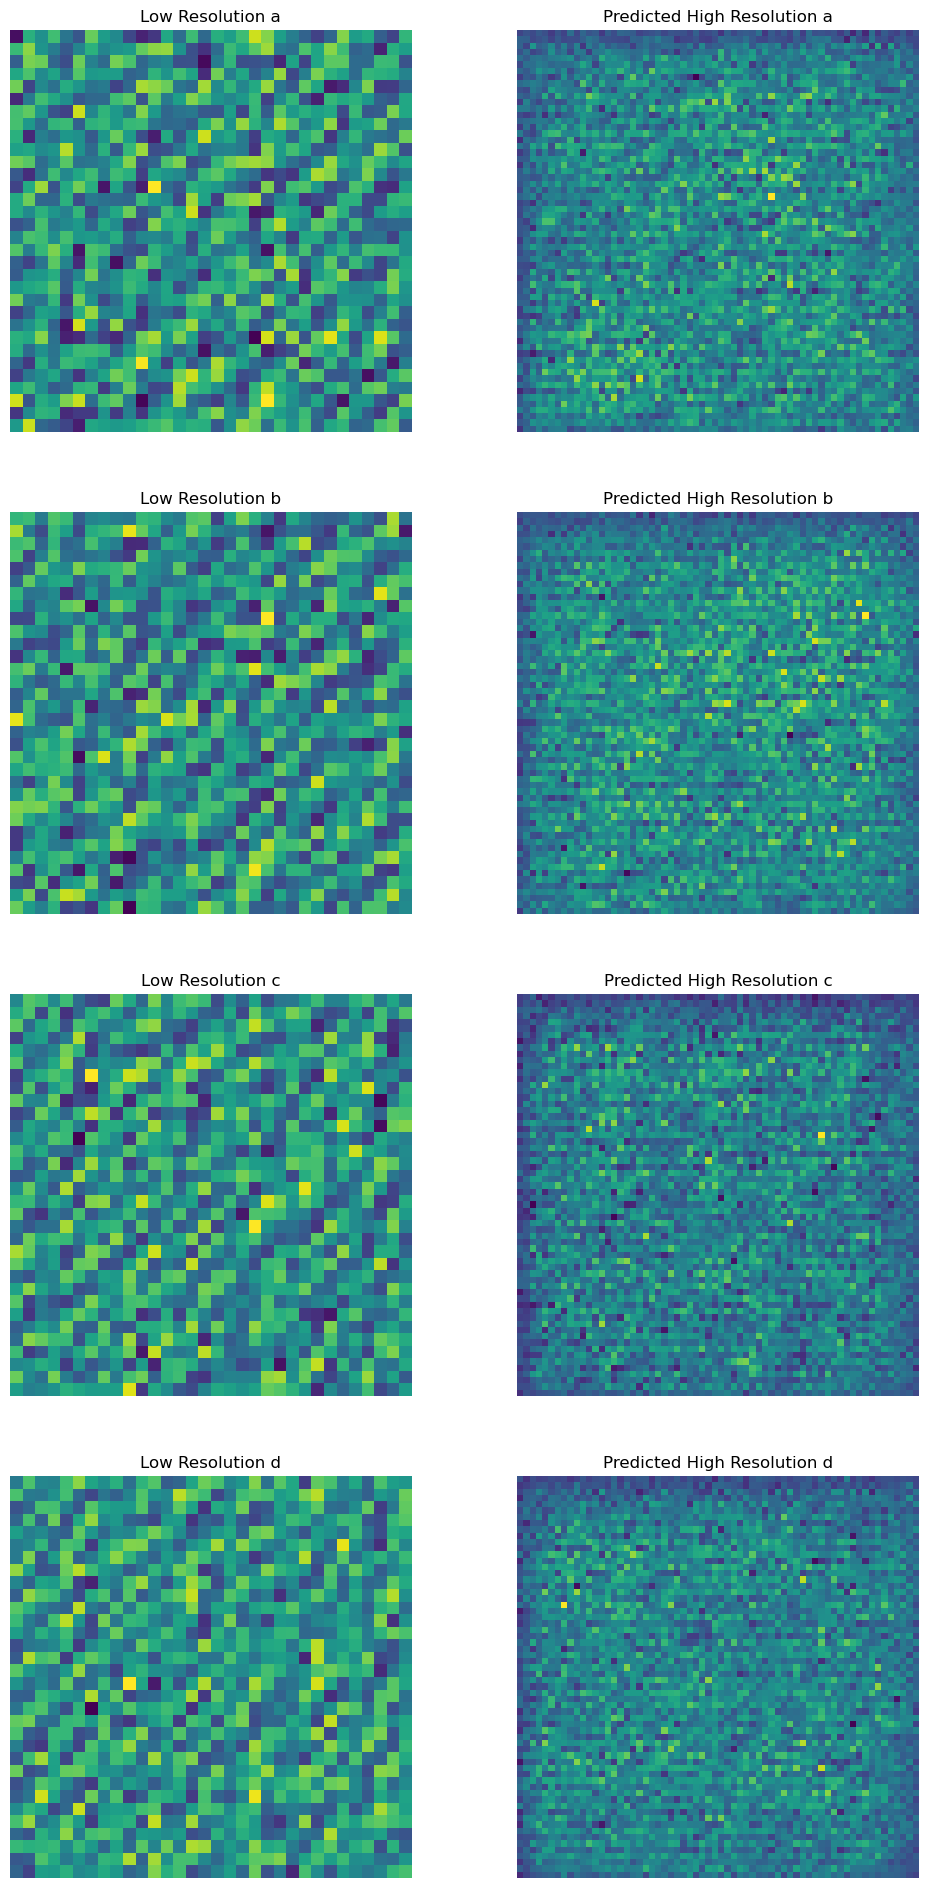

In [11]:
import paddle
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 定义生成器模型
class GeneratorG(nn.Layer):
    def __init__(self):
        super(GeneratorG, self).__init__()
        self.conv1 = nn.Conv2D(1, 64, 9, padding=4)
        self.conv2 = nn.Conv2D(64, 32, 5, padding=2)
        self.upsample = nn.Conv2DTranspose(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2D(32, 1, 5, padding=2)

    def forward(self, x):
        x = paddle.nn.functional.relu(self.conv1(x))
        x = paddle.nn.functional.relu(self.conv2(x))
        x = paddle.nn.functional.relu(self.upsample(x))
        x = self.conv3(x)
        return x

# 初始化模型
genG = GeneratorG()

# 加载预训练模型权重
model_path = "saved_models/genG.pdparams"
genG.set_state_dict(paddle.load(model_path))
genG.eval()

# 加载低分辨率数据
aCopy = np.load("aCopy.npy")
bCopy = np.load("bCopy.npy")
cCopy = np.load("cCopy.npy")
dCopy = np.load("dCopy.npy")

low_res_data = np.stack([aCopy, bCopy, cCopy, dCopy], axis=0)
low_res_data = paddle.to_tensor(low_res_data).astype('float32').unsqueeze(1)  # 添加通道维度

# 对abcd分别进行超分辨处理
with paddle.no_grad():
    high_res_data = genG(low_res_data)

# 确认输出尺寸是否正确
print(high_res_data.shape)

# 可视化结果
high_res_data = high_res_data.numpy()

fig, axs = plt.subplots(4, 2, figsize=(12, 24))

fields = ['a', 'b', 'c', 'd']
for i in range(4):
    axs[i, 0].imshow(low_res_data[i, 0], cmap='viridis', interpolation='nearest')
    axs[i, 0].set_title(f'Low Resolution {fields[i]}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(high_res_data[i, 0], cmap='viridis', interpolation='nearest')
    axs[i, 1].set_title(f'Predicted High Resolution {fields[i]}')
    axs[i, 1].axis('off')

plt.show()


# model C训练

给定波函数的abcd，我们得到速度场

## 